### Import Modules

In [1]:
import io, os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, TensorDataset

from sklearn import model_selection

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data parameter setting

In [6]:
DATA_NUM = 72192
IMAGE_PATH = '../input/hangul-images/hangul-images/hangul-images/'
LABEL_PATH = '../input/hangul-labels/'
OUTPUT_DIR = '../output/'
if not os.path.exists(OUTPUT_DIR) : os.makedirs(OUTPUT_DIR)

### Load Datasets

In [4]:
def get_data(data_num, file_path):
    dataset = []
    for i in range(1, data_num+1):
        with Image.open(file_path + "hangul_{}.jpeg".format(i)) as image:
            data = np.array(image)
            data = data / 255
        dataset.append(data)
    dataset = np.array(dataset)
    dataset = dataset.reshape(len(dataset), 1, 64, 64)
    return dataset

In [7]:
%%time
hangul_dataset = get_data(DATA_NUM, IMAGE_PATH)

CPU times: user 20.5 s, sys: 10.4 s, total: 30.9 s
Wall time: 2min 23s


In [8]:
print("Data:", len(hangul_dataset))
print("Image size:", hangul_dataset[0].shape)

Data: 72192
Image size: (1, 64, 64)


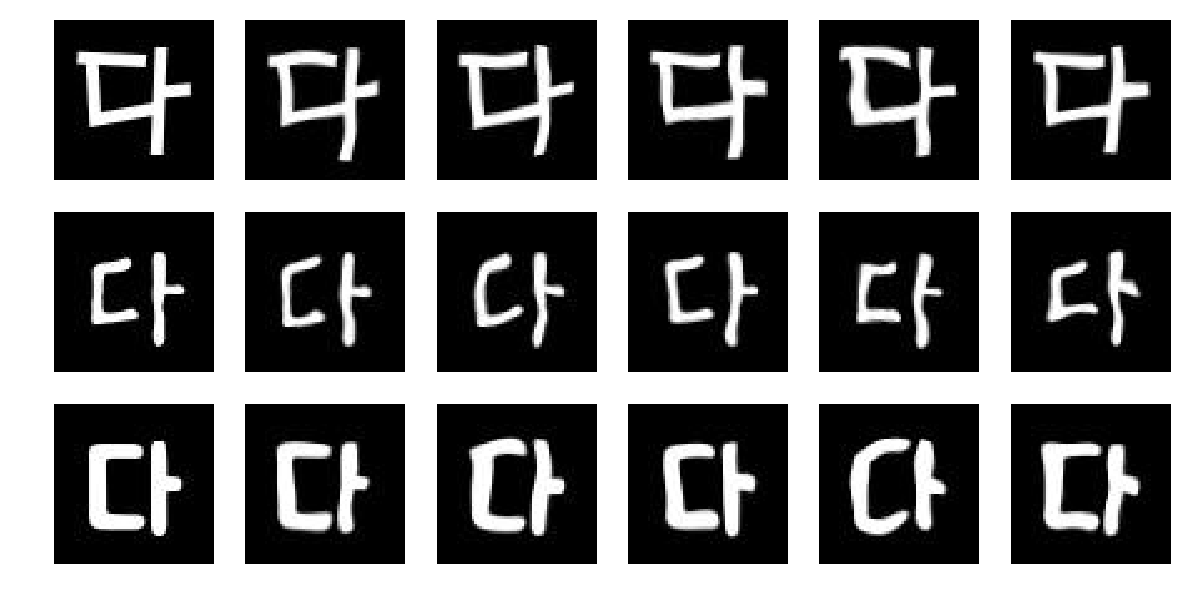

In [9]:
plt.figure(figsize=(10, 5))
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(hangul_dataset[i].reshape(64, 64), cmap="gray")
    plt.grid()
    plt.axis("off")
plt.show()

In [10]:
labels_df = pd.read_csv("../input/hangul-labels/labels-map.csv")
print(labels_df.shape)
labels_df.head()

(72192, 2)


,file_path,label
0,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,다
1,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,다
2,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,다
3,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,다
4,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,다


In [11]:
labels = labels_df['label'].values
print(len(labels))
labels[:10]

72192


array(['다', '다', '다', '다', '다', '다', '다', '다', '다', '다'], dtype=object)

- 글자당 282개씩 들어가있으므로, ohe는 0~255의 숫자로 할당

In [12]:
ohe_labels = np.array([[i] * 282 for i in range(256)])
ohe_labels = ohe_labels.reshape(-1)
print(len(ohe_labels))
ohe_labels

72192


array([  0,   0,   0, ..., 255, 255, 255])

In [13]:
labels_df['ohe_label'] = ohe_labels
labels_df.tail()

,file_path,label,ohe_label
72187,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,태,255
72188,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,태,255
72189,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,태,255
72190,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,태,255
72191,/Users/minn/Dev/Fastcampus/DSS/Project/Final_p...,태,255


### Make Tensor

In [14]:
X = torch.from_numpy(hangul_dataset).float()
y = torch.from_numpy(ohe_labels).long()

X.shape, y.shape

(torch.Size([72192, 1, 64, 64]), torch.Size([72192]))

In [15]:
train = TensorDataset(X, y)
train[0][0].shape, train[0][1]

(torch.Size([1, 64, 64]), tensor(0))

tensor(255)


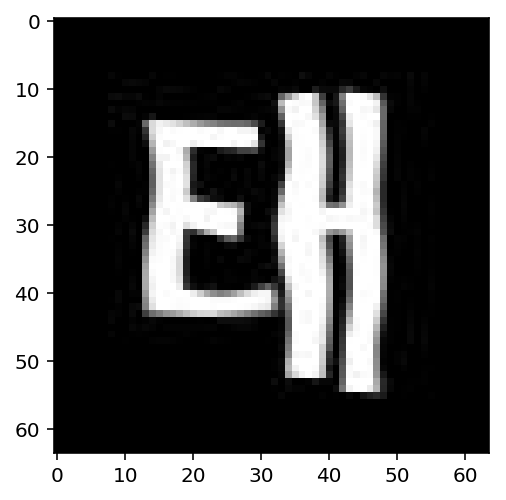

In [16]:
print(train[-1][1])
plt.imshow(train[-1][0].reshape(64, 64), cmap='gray')
plt.show()

### Define Model

In [28]:
MAX_EPOCH = 20
BATCH_SIZE = 100
lr = 0.0002
z_dim = 128
image_size = 64
log_step = 100
sample_step = 500
sample_num = 32

In [17]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
def conv(c_in, c_out, k_size, stride=2, padding=1, bn=True):
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, padding))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, image_size=image_size, conv_dim=32):
        super(Discriminator, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.fc = conv(conv_dim*8, 1, int(image_size/16), stride=1, padding=0, bn=False)
    
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)
        out = F.leaky_relu(self.conv2(out), 0.05)
        out = F.leaky_relu(self.conv3(out), 0.05)
        out = F.leaky_relu(self.conv4(out), 0.05)
        out = self.fc(out).squeeze()
        return out.unsqueeze(1)
    
D = Discriminator()
D.cuda()

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [22]:
def deconv(c_in, c_out, k_size, stride=2, padding=1, bn=True):
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, padding))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self, z_dim=z_dim, image_size=image_size, conv_dim=32):
        super(Generator, self).__init__()
        self.fc = deconv(z_dim, conv_dim*8, 4)
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 1, 4, bn=False)
    
    def foward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1,)
        out = self.fc(z)
        out = F.leaky_relu(self.deconv1(out), 0.05)
        out = F.leaky_relu(self.deconv2(out), 0.05)
        out = F.leaky_relu(self.deconv3(out), 0.05)
        out = F.tanh(self.deconv4(out))
        return out
    
G = Generator()
G.cuda()

Generator(
  (fc): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

### Loss / Optimizer

In [24]:
criterion = nn.BCELoss().cuda()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

### Training

In [ ]:
try:
    G.load_state_dict(torch.load('../generator.pkl'))
    D.load_state_dict(torch.load('../discriminator.pkl'))
    print("model restored")
except:
    print("model not restored")
    pass

In [36]:
total_batch = len(train_loader.dataset) // BATCH_SIZE
fixed_z = torch.randn(sample_num, z_dim).cuda()
for epoch in range(MAX_EPOCH):
    for idx, (images, label) in enumerate(train_loader):
        images = images.cuda()
        real_labels = torch.ones(BATCH_SIZE, 1).cuda()
        real_labels = torch.zeros(BATCH_SIZE, 1).cuda()
        
        # === Train Discriminator === #
        
        # real image scoring
        real_prob = D(images)
        print(real_prob.shape, real_labels.shape)
        d_loss_real = criterion(real_prob, real_labels)
        real_score = real_prob
        
        # fake image generating
        z = torch.randn(batch_size, z_dim).cuda()
        fake_images = G(z)
        
        #fake image scoring
        fake_prob = D(fake_images)
        d_loss_fake = criterion(fake_prob, fake_labels)
        fake_score = fake_prob
        
        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # === Train Generator === #
        
        # fake image scoring
        z = torch.randn(batch_size, z_dim).cuda()
        fake_images = G(z)
        fake_prob = D(fake_images)
        
        # calculate loss
        g_loss = torch.mean((fake_prob - 1) ** 2) # Least Square
        
        # Backprop + Optimize
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss [{.4f}], g_loss [{.4f}], D(x): {.2f}, D(G(z)): {.2f}'.format(epoch, MAX_EPOCH, i+1, total_batch, \
                                                                                                                    d_loss.item(), g_loss.item(), \
                                                                                                                    real_score.data.mean(), \
                                                                                                                    fake_score.data.mean()))
        if (i+1) % sample_step == 0:
            fake_images = G(fized_z)
            torchvision.utils.save_image(fake_images.data, os.path('../fake_samples-{}-{}.png'.format(epoch+1, i+1), nrow=8))
            
torch.save(G.state_dict(), '../generator.pkl')
torch.save(D.state_dict(), '../discriminator.pkl')

RuntimeError: CUDA error: device-side assert triggered